In this notebook, we will:
1. load pretrained model
3. visualize local predictions
4. calculate map
5. make submission

## Imports

In [1]:
import numpy as np 
import pandas as pd
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils
import albumentations as alb
from math import sin, cos, sqrt, log, acos, pi
import functools
from scipy.spatial.transform import Rotation as R
%config InlineBackend.figure_format = 'retina'
PATH = '../data/'

## Load csv

In [2]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

REGR_TARGETS = sorted( ["vdiff", "udiff" ,"z" , "yaw","pitch_sin", "pitch_cos", "roll"] )

device = torch.device(f"cuda:{1}" if torch.cuda.is_available() else "cpu")

## Helper Functions

In [3]:
class args:
    PATH = '../data/'
    MODEL_PATH = '../models/'
    bad_files = ["ID_4d238ae90", "ID_1a5a10365", "ID_408f58e9f","ID_bb1d991f6","ID_c44983aeb"]
    # debug mode
    DEBUG = False # debug mode for sanity check

    # original image width and height
    ORIG_W = 3384
    ORIG_H = 2710
    
    IMG_WIDTH = 2048 # training image width
    IMG_HEIGHT = 512  # training image height
    MARGIN_W = ORIG_W // 4
    MODEL_SCALE = 8 # downsample ratio
    FX, FY = 2304.5479,  2305.8757 # camera params
    CX, CY = 1686.2379, 1354.9849 # camera params
    IMG_SHAPE = (2710, 3384, 3)

    # training params
    BATCH_SIZE = 2
    USEMASK = True
    AMP = False # automatic mixed precision training
    MULTI_GPU = False
    DEVICE_ID = 0 # GPU ID
    n_epochs = 50 
    n_worker = 10 # number of cpu threads
    seed = 888 
    DISTANCE_THRESH_CLEAR = 2 # distance post processing threshold
    heatmap_threshold = 0.45
    MODEL_PATH = '../models/model_epoch_37.pth'

In [4]:
# 
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]
_train_df = pd.read_csv(args.PATH + 'train.csv')

def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys
def preprocess_image(img, flip=False):
    '''
    [✔️] preprocess images, copied from public
    input:
        img: original image
        flip: hflip for augmentation
    output:
        img with pixel values between 0 and 1
    '''
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :3384//4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (2048, 512))
    if flip: # flip augmentation
        img = img[:,::-1]
    return (img / 255).astype('float32')
def preprocess_mask_image(img): 
    '''
    [✔️] preprocess masks (things we are not interested in)
    '''
    img = img[img.shape[0] // 2:]
    bg = np.zeros_like(img).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (2048, 512))  
    return (img / 255).astype('float32')
def get_hm_and_regr(img, labels, flip=False):
    '''
    [✔️] get heatmap and regression maps.
    input:
        image: preprocessed images, c x h x w
        labels: prediction strings from the csv
        flip: flip augmentation
    output:
        heatmap: heatmap given by gaussian 2d
        regr: regression mask
    '''
    # intialize heatmap and regr
    hm = np.zeros([args.IMG_HEIGHT // args.MODEL_SCALE, args.IMG_WIDTH // args.MODEL_SCALE], dtype='float32')
    regr = np.zeros([args.IMG_HEIGHT // args.MODEL_SCALE, args.IMG_WIDTH // args.MODEL_SCALE, 7], dtype='float32')

    # prediction string to coordinates 
    coords = str2coords(labels) 
    # get x and y on the image, using the given camera params
    xs, ys = get_img_coords(labels)
    # get z, depth
    zs = [e["z"] for e in coords]

    # from paper https://arxiv.org/pdf/1904.07850.pdf, section 3: L_offset
    # convert image coordinates to it's low-resolution  equivalent
    hm_V_arr, hm_U_arr = VU2hmVU( ys, xs )
    hm_V_arr_floor = np.floor( hm_V_arr ).astype('int') # low-resolution  equivalent
    hm_U_arr_floor = np.floor( hm_U_arr ).astype('int') # low-resolution  equivalent
    hm_V_diff = hm_V_arr - hm_V_arr_floor # we regress on this
    hm_U_diff = hm_U_arr - hm_U_arr_floor # we regress on this
    # make heatmap
    heatmap = make_heatmap(hm, hm_V_arr_floor, hm_U_arr_floor, zs)
    # construct regr_dict
    for hm_V, hm_U, vdiff,udiff, regr_dict in zip(hm_V_arr_floor, hm_U_arr_floor,hm_V_diff,hm_U_diff, coords):
        if hm_V >= 0 and hm_V < args.IMG_HEIGHT // args.MODEL_SCALE and hm_U >= 0 and hm_U < args.IMG_WIDTH // args.MODEL_SCALE:
            regr_dict = _regr_preprocess(regr_dict, vdiff, udiff)
            regr[hm_V, hm_U] = [regr_dict[n] for n in sorted(regr_dict)]
    # hflip, we need to do that for heatmap and regr as well
    if flip: 
        heatmap = np.array(heatmap[:,::-1])
        regr = np.array(regr[:,::-1])
    return heatmap, regr 
def XYZ2UV(x,y,z):
    '''
    [✔️] World Coordinate to image Coordinates
    '''
    u = args.FX * x / z + args.CX
    v = args.FY * y / z + args.CY
    return u,v
def UVZ2XY(u,v,z):
    '''
    [✔️] Image Coordinates to World Coordinates 
    '''
    x = z * (u - args.CX) / args.FX
    y = z * (v - args.CY) / args.FY
    return x,y
def VU2hmVU(v,u): 
    '''
    [✔️] In Image Coordinates, VU on the image to VU on the heatmap
    '''
    hm_V = (v - args.ORIG_H // 2) * args.IMG_HEIGHT / (args.ORIG_H // 2) / args.MODEL_SCALE
    hm_U = (u + args.MARGIN_W) * args.IMG_WIDTH  / (args.ORIG_W + 2*args.MARGIN_W) / args.MODEL_SCALE
    return hm_V, hm_U
def hmVU2VU(hm_v_float, hm_u_float):
    '''
    [✔️] In Image Coordinates, VU on the heatmap to VU on the image
    '''
    v = args.ORIG_H // 2 + hm_v_float * args.MODEL_SCALE / args.IMG_HEIGHT * (args.ORIG_H // 2)
    u = hm_u_float * args.MODEL_SCALE * (args.ORIG_W + 2*args.MARGIN_W) / args.IMG_WIDTH -args. MARGIN_W
    return v, u
def _regr_preprocess(regr_dict, vdiff, udiff):
    '''
    [✔️] preprocessing for regression
    input:
        regr_dict: a dictionary for regr contains id, yaw, pitch, roll, x, y, z
    output:
        regr_dict: modified dictionary with vdiff, udiff, roll, pitch_sin, pitch_cos, log(z)
    '''
    regr_dict["vdiff"] = vdiff
    regr_dict["udiff"] = udiff

    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])

    # follow original center3D paper appendix B: 3D BBOX Estimation Details
    regr_dict["z"] = np.log(regr_dict["z"])
    
    regr_dict.pop('x')
    regr_dict.pop('y')
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict
def _regr_back(regr_dict, hm_V_pos, hm_U_pos):
    '''
    [✔️] Recover from heatmap
    input:
        regr_dict: a dictionary
        hm_V_pos: V position on the heatmap
        hm_U_pos: U position on the heatmap
    output:
        regr_dict: regr backed dictionary
    '''
    regr_dict["z"] = np.exp(regr_dict["z"]) # invsigmoid(1/(regr_dict["z"]+1))
    _v, _u = hmVU2VU( hm_V_pos + regr_dict["vdiff"], hm_U_pos + regr_dict["udiff"])
    regr_dict["x"], regr_dict["y"] = UVZ2XY(_u, _v, regr_dict["z"])
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    
    return regr_dict
def preprocess_image(img, flip=False):
    '''
    [✔️] preprocess images, copied from public
    input:
        img: original image
        flip: hflip for augmentation
    output:
        img with pixel values between 0 and 1
    '''
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :args.MARGIN_W]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (args.IMG_WIDTH, args.IMG_HEIGHT))
    if flip: # flip augmentation
        img = img[:,::-1]
    return (img / 255).astype('float32')
def preprocess_mask_image(img): 
    '''
    [✔️] preprocess masks (things we are not interested in)
    '''
    img = img[img.shape[0] // 2:]
    bg = np.zeros_like(img).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (args.IMG_WIDTH, args.IMG_HEIGHT))  
    return (img / 255).astype('float32')
# https://github.com/xingyizhou/CenterNet/blob/master/src/lib/utils/image.py
def draw_msra_gaussian(heatmap, center, sigma):
    '''
    [✔️] draw gaussian heatmap (helper)
    '''
    tmp_size = np.ceil(sigma * 3).astype(int) # fix
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap
def gaussian2D(shape, sigma=1):
    '''
    [✔️] gaussian 2D assignment around the keypoint
    '''
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h
def make_heatmap(m, v_arr, u_arr, z_arr):
    '''
    [✔️] draw gaussian heatmap (main)
    '''
    for v,u,z in zip(v_arr, u_arr, z_arr):
        sigma = 800 / 3.  / z / args.MODEL_SCALE
        m = draw_msra_gaussian(m, (u,v), sigma)
    return m
def rotate(x, angle):
    '''
    Function that rotate roll, for orientation
    '''
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x
def postprocess_heatmap(logits, thresh=0.45):
    '''
    [✔️] This is like an NMS, max pooling is used in the paper
    '''
    prob = sigmoid(logits)
    mp2d = torch.nn.MaxPool2d(3, stride=1, padding=1, dilation=1, return_indices=False, ceil_mode=False)
    out = mp2d( torch.Tensor([[prob]]) ).numpy()[0][0]
    return (prob == out) & (prob > thresh)
def sigmoid(x):
    '''
    [✔️] sigmoid function for regression
    '''
    return 1 / (1 + np.exp(-x))
def extract_coords(prediction, ignore_mask):
    '''
    [✔️] Coordinates extraction
    input:
        prediction: prediction that contains logits and regression targets
        ignore_mask: a mask that contains targets that we are not interested in
    output:
        coords: predicted values, we will turn them to strings later
    '''
    logits = prediction[0]
    regr_output = prediction[1:]
    points_mat = postprocess_heatmap(logits, thresh = args.heatmap_threshold) 
    points = np.argwhere( points_mat > 0 )
    coords = []
    for v, u in points:           
        regr_dict = dict(zip(REGR_TARGETS, regr_output[:, v, u]))
        regr_backed = _regr_back(regr_dict, v, u)
        _U, _V = XYZ2UV(regr_backed["x"], regr_backed["y"], regr_backed["z"])
        _U, _V = int(_U), int(_V)
        # determine if it's in the ignored mask
        if _V>=0 and _V < args.ORIG_H and _U>=0 and _U < args.ORIG_W and ignore_mask[_V,_U] > 0.5:  
            continue # if it is, we don't add it to coords
        coords.append(regr_backed)
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[v, u])) # sigmoid, whether it's a car or not
        coords = clear_duplicates(coords)
    return coords
def clear_duplicates(coords):
    '''
    [✔️] clear duplicates for post processing, this is not nms or maxpooling
    '''
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            # calcula
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < args.DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image
def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image
def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    '''
    [✔️] turn coords prediction to string
    input:
        coords: predicted values, we will turn them to strings here
    output:
        predicted strings
    '''
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)
def calc_map(valid_df):
    if np.all( valid_df.dropna().PredictionString == "" ):  # no pred
        return 0.0

    expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])

    val_label_df = _train_df[_train_df.ImageId.isin(valid_df.ImageId.unique())]
    # data description page says, The pose information is formatted as
    # model type, yaw, pitch, roll, x, y, z
    # but it doesn't, and it should be
    # model type, pitch, yaw, roll, x, y, z
    expanded_val_label_df = expand_df(val_label_df, ['model_type','pitch','yaw','roll','x','y','z'])

    n_gt = len(expanded_val_label_df)
    ap_list = []

    eval_func = functools.partial(check_match, val_label_df, valid_df)

    for _i in range(10):
        result_flg, scores = eval_func(_i)

        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt

        ### randomized score version
        ### https://www.kaggle.com/c/pku-autonomous-driving/discussion/124489
        # ap = average_precision_score(result_flg, scores)*recall
        if False:
            ap = average_precision_score(result_flg, np.random.rand(len(result_flg)))*recall
        else: # pure precision * recall
            ap = np.mean(result_flg) * recall
        ap_list.append(ap)

    return np.mean(ap_list)
def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    assert len(PredictionStringCols) == 7
    idarr = []
    tmparr = []
    for imgid, predstr in zip( df['ImageId'], df['PredictionString']):
        if predstr == "":
            continue
        coords = np.array(predstr.split(' ')).reshape(-1,7).astype(float)
        for cor in coords:
            idarr.append(imgid)
            tmparr.append(  cor.tolist() )
    
    prediction_strings_expanded = np.array(tmparr)
    df = pd.DataFrame(
        {
#            'ImageId': image_id_expanded,
            'ImageId': idarr,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df
def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff
def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W
def check_match(train_df, valid_df, idx):  # train_df==TrueLabel, valid_df==Prediction
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords_dev(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords_dev(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores

In [5]:
# center-resnet copied from https://www.kaggle.com/phoenix9032/center-resnet-starter
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x
def get_mesh(batch_size, shape_x, shape_y):
    '''
    Get mesh based on shape x and shape y
    One batch's mesh looks like:
                0 ................ 1
                . ................ 1
                . 
                .
                0 ................ 1
    but why does it work? lol
    '''
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out
class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, input_channels=3):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model
def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = resnet18(pretrained=False, input_channels=6)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

        if True: # use mask another channel
            self.conv0 = double_conv(5 + 1, 64) # total of 6 channels: 6 = 3(RGB) + 1(mask) + 2(MESH)
        else:
            self.conv0 = double_conv(5, 64)
            
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        if True:
            feats8, feats16, feats32 = self.base_model(x0) # x0 has total of 6 channels: 6 = 3(RGB) + 1(mask) + 2(MESH)
        else:
            feats8, feats16, feats32 = self.base_model(x)

        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        x = self.up1(feats, x4) 
        x = self.up2(x, x3)
        x = self.outc(x)
        return x
def mask_forward(img, ignore_mask):  
    '''
    [✔️] use mask as another channel and feed it into the model
    input:
        img: image
        ignore_mask: mask for non-interested images
    '''
    return model(torch.from_numpy(np.concatenate((img, ignore_mask),axis=1)).to(device) )
def str2coords_dev(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords
class CompetitionDataset(Dataset):
    '''
    Competition Dataset:
    Initialization:
        dataframe: original csv
        root_dir: directory of images
        mask_root_dir: directory of mask
        mode: mode for dataset creation, train, valid or test
        transforms: custom training transformation
    Output:
        img: preprocessed images
        hm: heatmap
        regr: regression targets
        ignore_img: original mask for car out of interest
        ignore_img_forward: mask for forward, same aspect ratio as preprocessed images
    '''

    def __init__(self, dataframe, root_dir, mask_root_dir, mode='train', transforms=False):
        self.df = dataframe # dataframe, csv
        self.root_dir = root_dir # root directory for images
        self.mask_root_dir = mask_root_dir # root directory for images
        self.mode = mode # mode for training or inference 
        self.transforms = transforms # custom transformation
        print(f'[✔️] Dataset initiated in {mode} mode.')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        img = cv2.imread(img_name)[:,:,::-1] # bgr to rgb

        if self.transforms: 
            img = self.transforms(image=img)["image"] # apply transformation

        if self.mode == 'train': # if training mode, perform flip augmentation with p = 0.5
            flip = False
            if np.random.rand() < 0.5: 
                flip = True # hflip
        elif self.mode == 'valid' or self.mode == 'test': # no flip during validation or test
            flip = False 

        img = preprocess_image(img, flip=flip) # preprocessing
        img = np.rollaxis(img, 2, 0) # channel first
        
        # the dataset also contains mask the masks for cars that are not of interest
        ignore_img = cv2.imread(self.mask_root_dir.format(idx), cv2.IMREAD_GRAYSCALE)
        if ignore_img is None:  # some pics has no mask, we create fake mask with all zeros
            ignore_img = np.zeros((2710, 3384), dtype='float32')

        ignore_img = np.array(ignore_img).astype('float32') / 255.
        # do this for mask to get the same aspect ratio 
        ignore_img_forward = preprocess_mask_image(ignore_img)
        #  h,w -> 1,h,w, add a channel(gray)
        ignore_img_forward = np.expand_dims(ignore_img_forward, 0) 
        
        # Get heatmap and regression maps
        if self.mode != 'test': 
            hm, regr = get_hm_and_regr(img, labels, flip)
            regr = np.rollaxis(regr, 2, 0) # channel first
        else:
            hm, regr = 0, 0 # no heatmap and regression target if we are at test phase
        
        return [img, hm, regr, ignore_img, ignore_img_forward]

In [6]:
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'
train_masks_dir = PATH + 'train_masks/{}.jpg'
test_masks_dir = PATH + 'test_masks/{}.jpg'

df_train, df_valid = train_test_split(train, test_size=0.1, random_state=888)
df_test = test

train_dataset = CompetitionDataset(df_train, train_images_dir, train_masks_dir, mode='train')
valid_dataset = CompetitionDataset(df_valid, train_images_dir, train_masks_dir, mode='valid')
test_dataset = CompetitionDataset(df_test, test_images_dir, test_masks_dir, mode='test')

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers = 8)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=8, shuffle=False, num_workers = 8)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers = 8)

[✔️] Dataset initiated in train mode.
[✔️] Dataset initiated in valid mode.
[✔️] Dataset initiated in test mode.


## 1. Load Pretrained Model

In [7]:
model = CentResnet(8).to(device)
model.load_state_dict(torch.load(args.MODEL_PATH, map_location=device))

<All keys matched successfully>

## 2. Visualize local Predictions

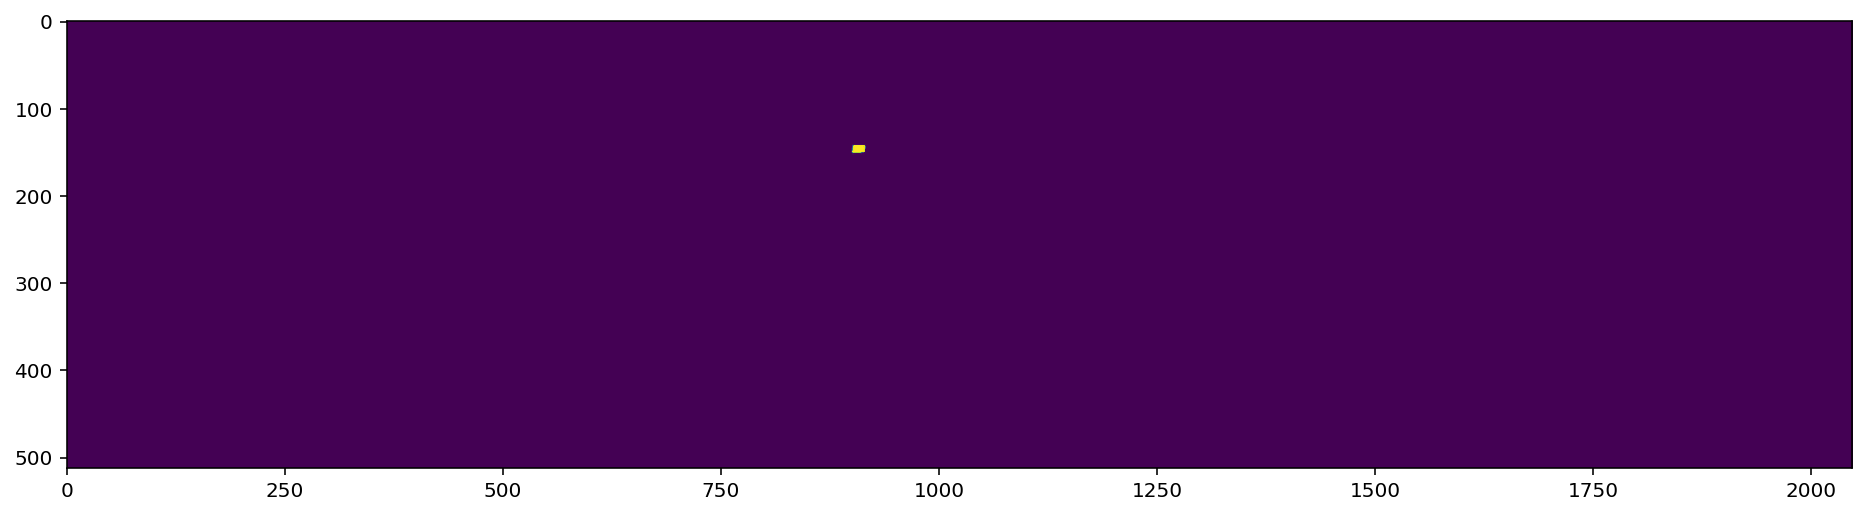

In [33]:
plt.figure(figsize=(16,16))
plt.imshow(ignore_mask_for_feed.squeeze())

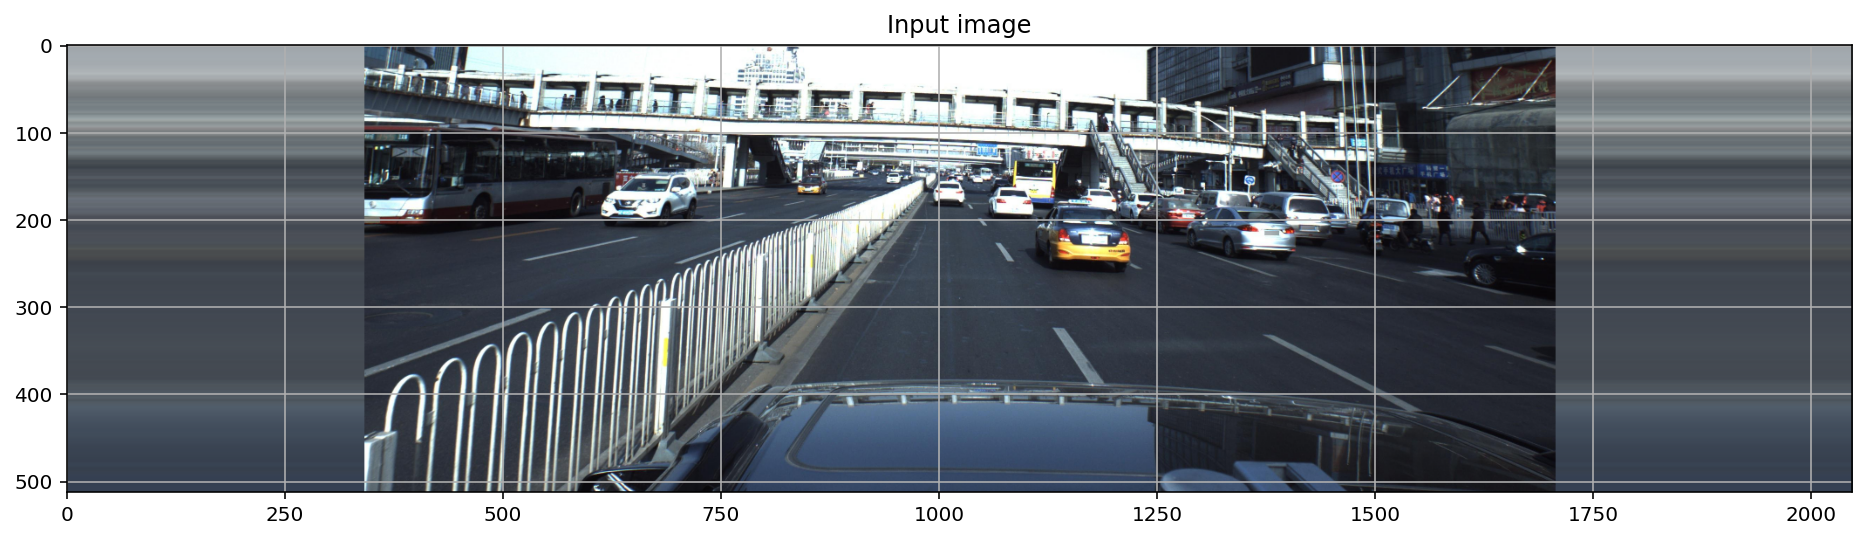

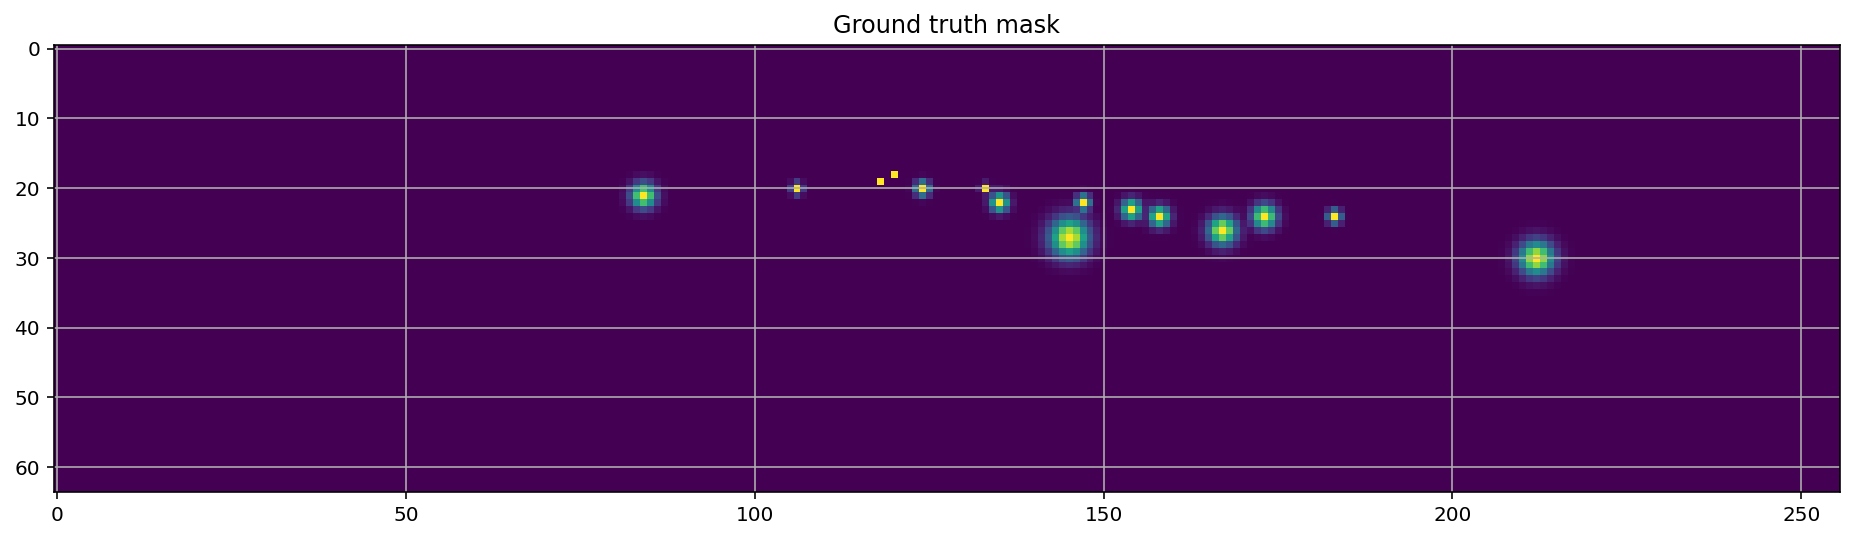

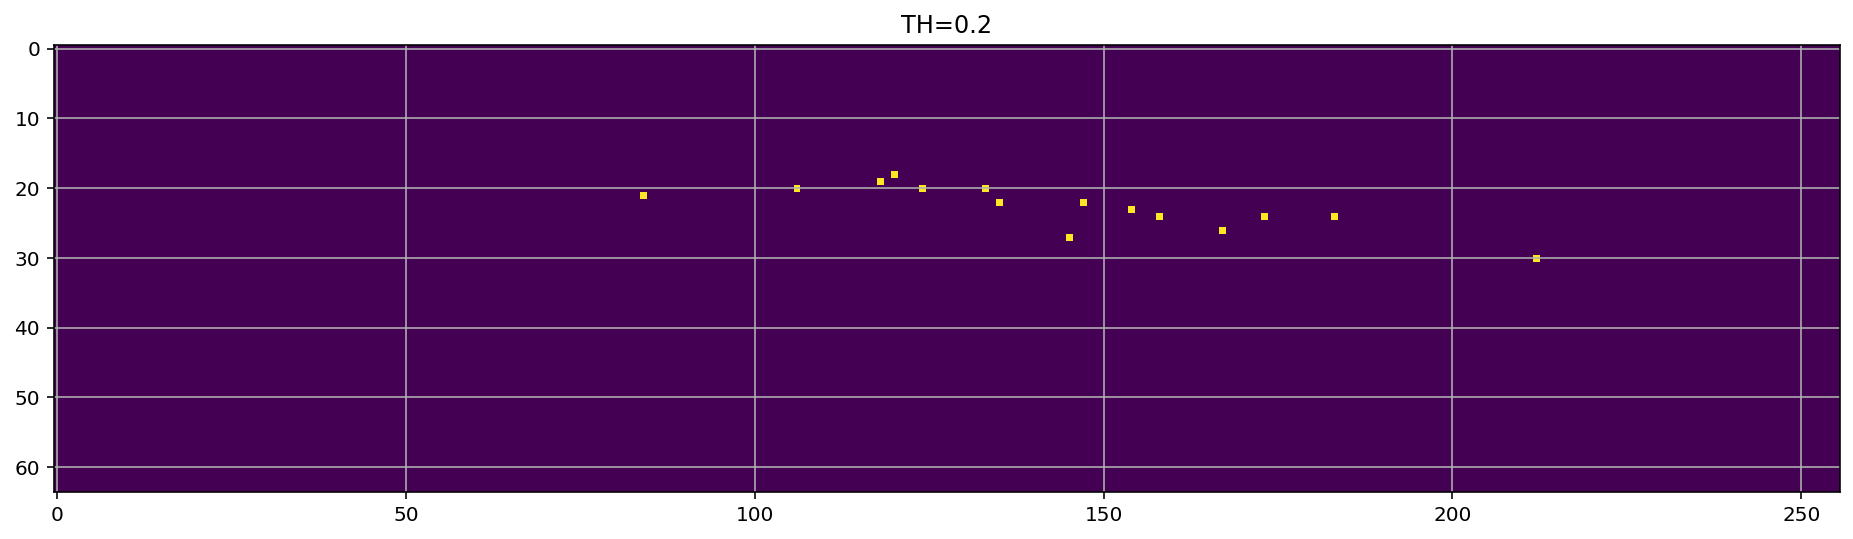

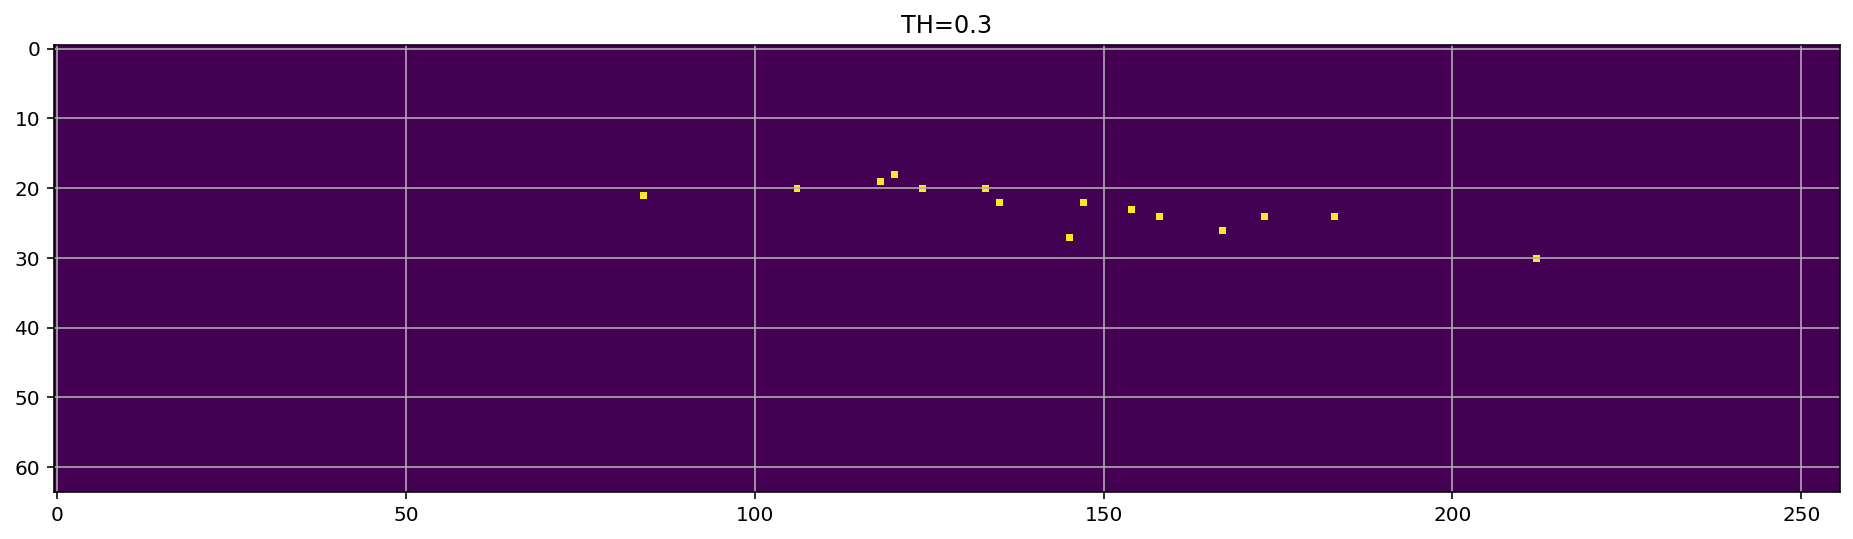

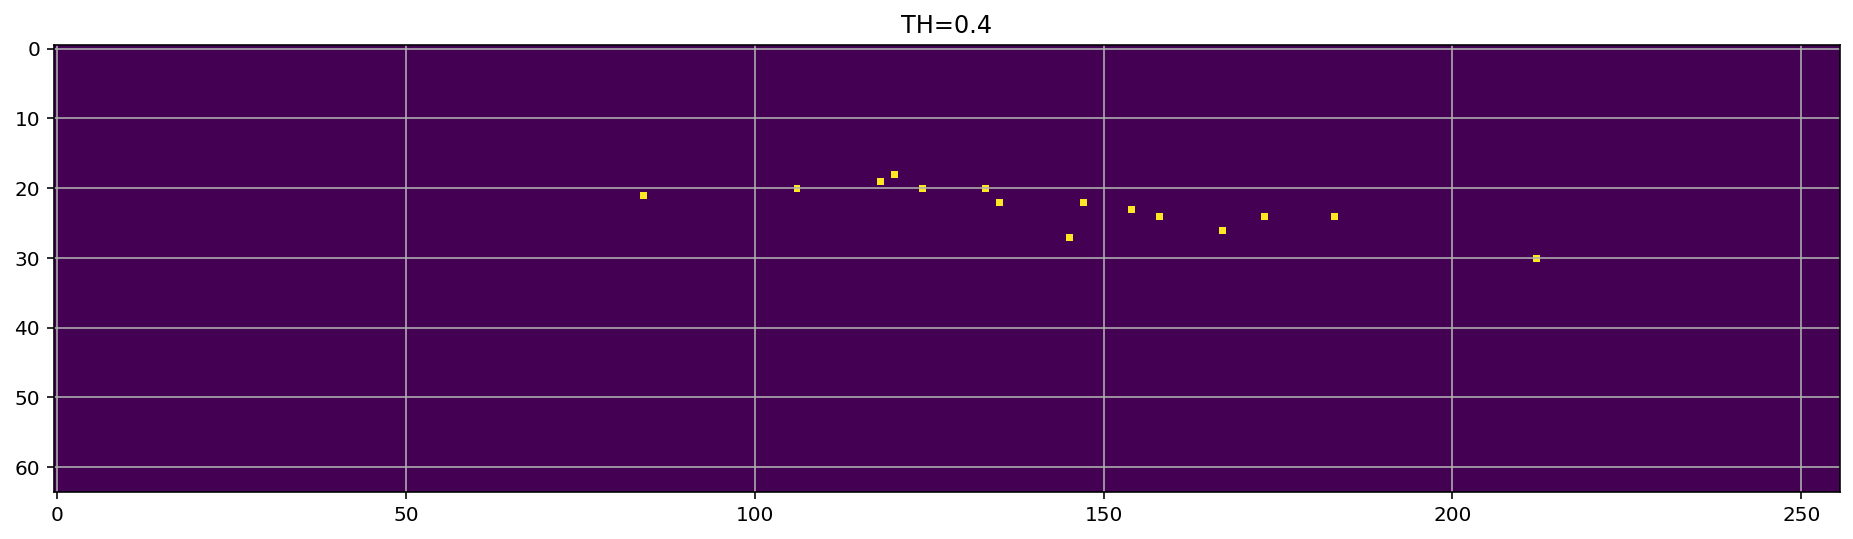

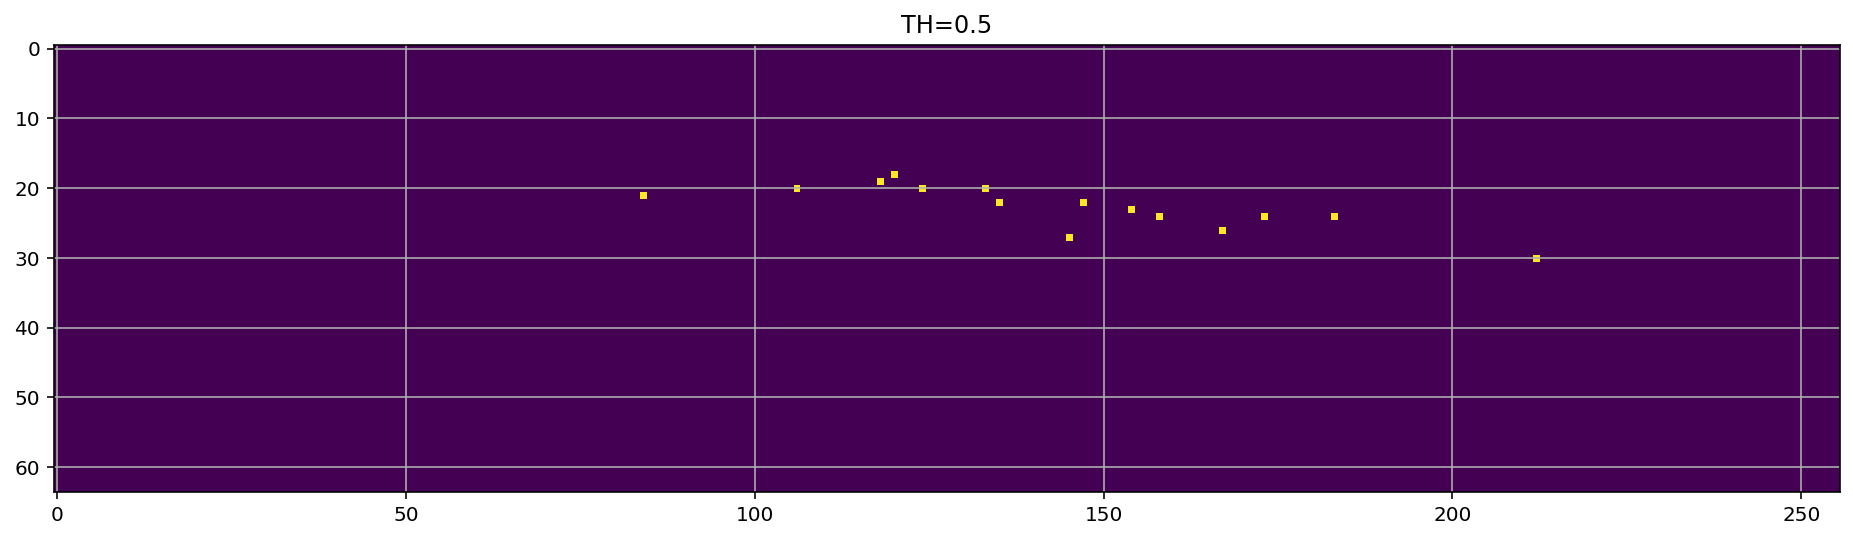

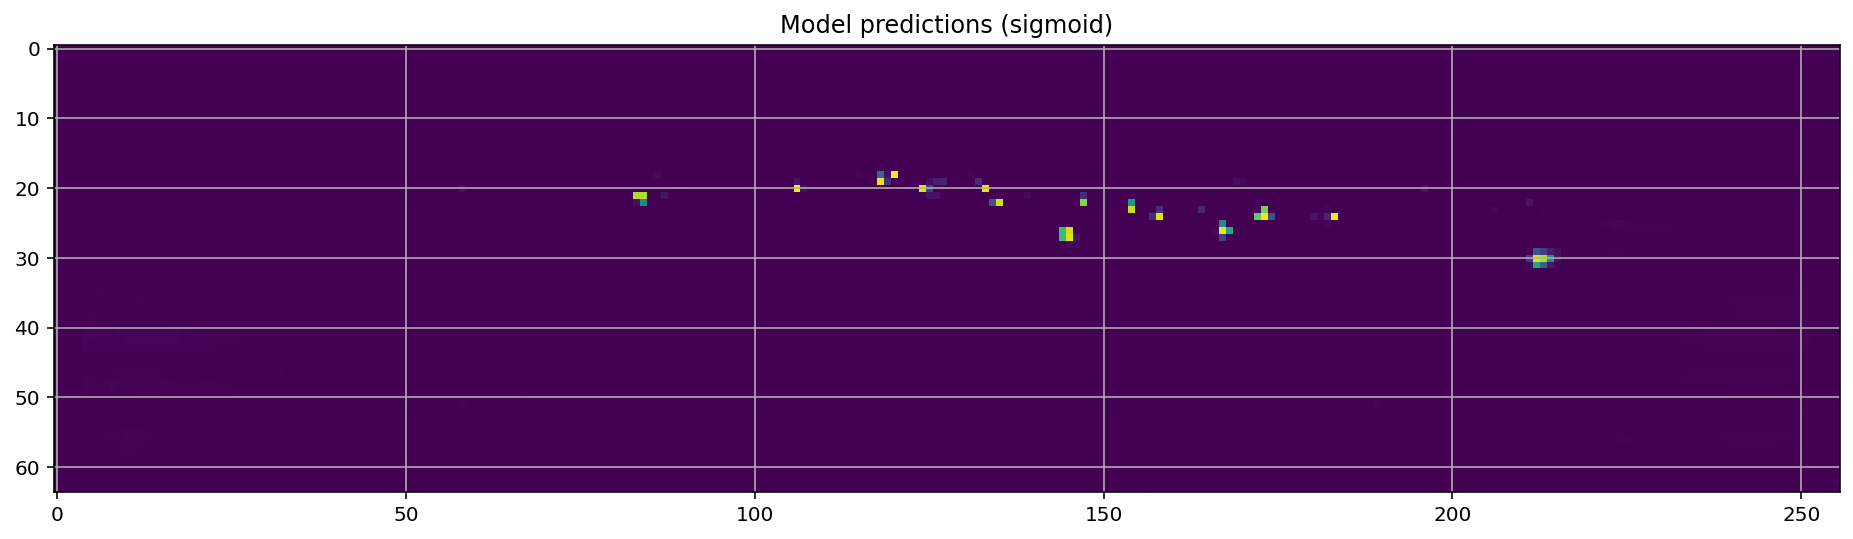

In [16]:
img, mask, regr, ignore_mask, ignore_mask_for_feed = valid_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.grid()
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.grid()
plt.imshow(mask)
plt.show()

if args.USEMASK:
    output = mask_forward(img[None], ignore_mask_for_feed[None])
else:
    output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('TH=0.2')
plt.grid()
plt.imshow(postprocess_heatmap(logits, thresh=0.2))
plt.show()

plt.figure(figsize=(16,16))
plt.title('TH=0.3')
plt.grid()
plt.imshow(postprocess_heatmap(logits, thresh=0.3 ))
plt.show()

plt.figure(figsize=(16,16))
plt.title('TH=0.4')
plt.grid()
plt.imshow(postprocess_heatmap(logits, thresh=0.4 ))
plt.show()

plt.figure(figsize=(16,16))
plt.title('TH=0.5')
plt.grid()
plt.imshow(postprocess_heatmap(logits, thresh=0.5))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions (sigmoid)')
plt.grid()
plt.imshow(sigmoid(logits))
plt.show()

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

for idx in range(8):
    img, heatmap, regr, ignore_mask, ignore_mask_for_feed = valid_dataset[idx]
    mask = (heatmap >= 1).astype(float)
    if args.USEMASK:
        output = mask_forward(img[None], ignore_mask_for_feed[None])
        output = output.data.cpu().numpy()
    else:
        output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()

    coords_pred = extract_coords(output[0], ignore_mask)
    
    perfect_logits = 1000 * ( ( heatmap==1 ).astype(float) - 0.5 )
    coords_true = extract_coords(np.concatenate([perfect_logits[None], regr], 0), ignore_mask)
    
    img = imread(train_images_dir.format(df_valid['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    # axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[0].axis('off')
    # axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    axes[1].axis('off')
    plt.show()

## 3. Calculate Local Map on the Validation Set

In [10]:
valid_predictions = []

valid_loader = DataLoader(dataset=valid_dataset, batch_size=8, shuffle=False, num_workers=8)

model.eval()

for img, _, _, ignore_masks, ignore_mask_for_feed_batch in tqdm(valid_loader):
    with torch.no_grad():
        if args.USEMASK:
            output = mask_forward(img, ignore_mask_for_feed_batch)
        else:
            output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out, ignore_mask in zip(output, ignore_masks):
        coords = extract_coords(out, ignore_mask)
        s = coords2str(coords)
        valid_predictions.append(s)

In [11]:
CV_valid = pd.DataFrame()
CV_valid["ImageId"] = df_valid.ImageId.copy()
CV_valid['PredictionString'] = valid_predictions
CV_valid.head()

,ImageId,PredictionString
683,ID_834465566,0.15581551 3.119926406043141 -3.10876895685727...
1518,ID_41db65a68,0.16983598 -3.134419594232974 -3.1084763837331...
1010,ID_8c9d65046,0.16540423 2.715672732432372 -3.12171753321821...
3171,ID_f6c352e5d,0.15194902 3.1371750397535516 -3.1071405207091...
3752,ID_8796a6eb6,0.14662096 3.0966377793053548 -3.0981317145102...


In [12]:
calc_map(CV_valid)

0.2191700980732592

## 4. Make Submission

In [13]:
predictions = []

model.eval()

for img, _, _, ign_masks, ign_mask_for_feed_batch in tqdm(test_loader):
    with torch.no_grad():
        if args.USEMASK:
            output = mask_forward(img, ign_mask_for_feed_batch)
        else:
            output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out, ign_mask in zip(output, ign_masks):
        coords = extract_coords(out, ign_mask)
        s = coords2str(coords)
        predictions.append(s)

In [14]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('test_sigmoid_threshold03_epoch37.csv', index=False)
test.head()

,ImageId,PredictionString
0,ID_18fb86d04,0.15133488 0.02335785259561545 -3.104731241362...
1,ID_ce06d4dc1,0.13394885 -0.010758004834657713 -3.0777918269...
2,ID_afe07078f,0.14365055 0.04998706652846491 -3.095509791868...
3,ID_37caf75aa,0.14852402 -0.001394897620229868 -3.0817505364...
4,ID_7655363ca,0.15797377 -3.1321634308003645 -3.117704419540...
